## SAGA Paper 4, FIGURE 2

In [1]:
import numpy as np

from myplotstyle import plt,get_figsize
%matplotlib inline

from scipy import stats
from matplotlib import cm
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator
from matplotlib import colors

import matplotlib.backends.backend_pdf
from mpl_toolkits.axes_grid1 import make_axes_locatable

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from SAGA.objects import calc_sfr


In [2]:
saga   = SAGA.QuickStart()

SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

sats  = C.is_sat.filter(base)
hosts = C.is_host.filter(base)

## For plotting, set lower limit for Halpha SFR

In [4]:
hasfr,herr  = calc_sfr.calc_SFR_Halpha(sats['EW_Halpha'], sats['EW_Halpha_err'], sats['SPEC_Z'], \
                         sats['SPEC_Z_ERR'],sats['Mr'],sats['r_err'])


/Users/mg37/opt/anaconda3/lib/python3.9/site-packages/SAGA/objects/calc_sfr.py:66: RuntimeWarning: invalid value encountered in log10
  log_Ha_SFR = np.log10(SFR)


In [5]:
m1 = (np.isfinite(sats['Halpha_sfr'])) 
m2 = (sats['quenched'] == 1)
mm = ~m1&m2

sats['Halpha_sfr'][mm] = hasfr[mm] - sats['log_sm'][mm]

m = sats['EW_Halpha'] <= -2.5
sats['Halpha_sfr'][m] = -11.25 + sats['log_sm'][m]

## LMC/SMC values

In [6]:
# LMC 2.7×109M⊙ (van der Marel 2006)
# https://ui.adsabs.harvard.edu/abs/2022MNRAS.513L..40M/abstract  
#
# SMC stellar mass: https://academic.oup.com/mnras/article/395/1/342/1746753
# SMC SFR:  Bolatto 2011 Sect 3.1:  https://iopscience.iop.org/article/10.1088/0004-637X/741/1/12

mw_mc_sfr = np.array([np.log10(0.1),np.log10(0.05)])
mw_mc_sm  = np.array([np.log10(2.7e9),np.log10(4.3e8)])
mw_mc_ssfr = np.array([np.log10(0.1),np.log10(0.05)]) - mw_mc_sm

In [7]:
m=sats['quenched'] == 0
sf_sats = sats[m]
q_sats  = sats[~m]

# Print out some numbers

In [8]:
m=sats['nuv_mag_flag'] != -1
print('Number of satellites = ',np.size(sats))
print('Number of NUV satellites = ',np.sum(m))

mh = hosts['nuv_mag_flag'] != -1
print('Number of hosts = ',np.size(hosts))
print('Number of NUV hosts = ',np.sum(mh))

tm = hosts['log_sm'] < 10
hosts[tm]

msp = sats['HOSTID'] == 'pgc31636'

Number of satellites =  378
Number of NUV satellites =  355
Number of hosts =  101
Number of NUV hosts =  94


In [9]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [10]:
# DEFINE COLOR MAP
top       = cm.get_cmap('Reds_r', 128)
bottom    = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0.1, 0.75, 128)), bottom(np.linspace(0.25, 1, 128))))
newcmp    = colors.ListedColormap(newcolors, name='RedBlue')
divnorm   = colors.TwoSlopeNorm(vmin=-11.75, vcenter=-10., vmax=-8.5)

shifted_cmap = shiftedColorMap(newcmp, midpoint=0.215, name='shifted')


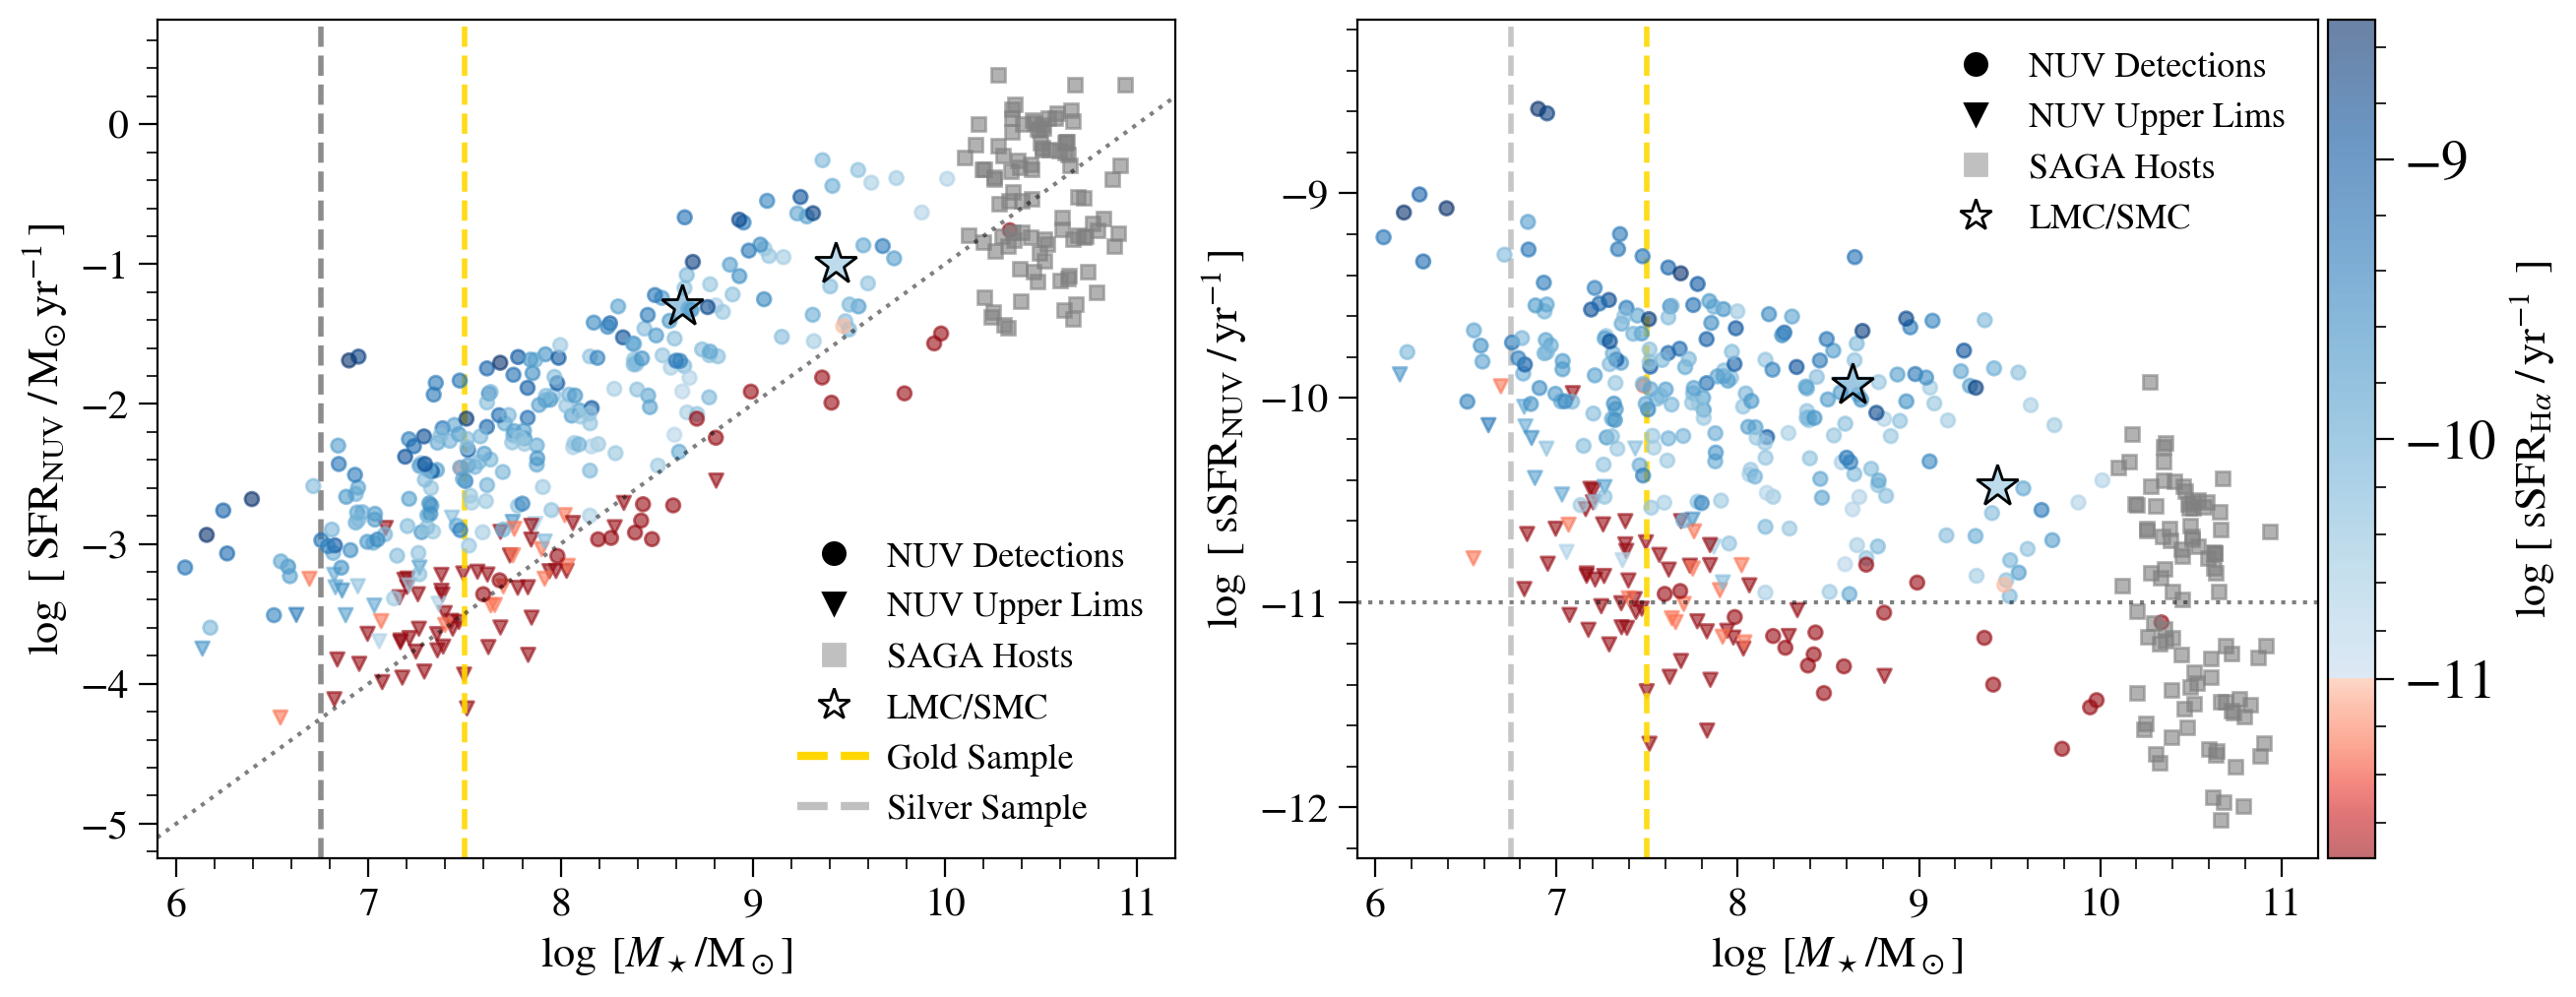

In [11]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_NUV_sSFR.pdf')

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=get_figsize(wide=True, ratio=2.5))
plt.rcParams.update({'font.size': 20})


ssfr = sats['Halpha_sfr'] - sats['log_sm']
m=sats['nuv_mag_flag'] ==1

ax1.scatter(sats['log_sm'][m],sats['nuv_sfr'][m],c=ssfr[m],\
            cmap = shifted_cmap, norm = divnorm,label='NUV Dectections',alpha=0.6,marker='o')

ax1.scatter(sats['log_sm'][~m],sats['nuv_sfr'][~m] ,c=ssfr[~m],\
            cmap = shifted_cmap, norm = divnorm,label='NUV upper limits',alpha=0.6,marker='v',zorder=0)

ax1.plot(hosts['log_sm'][mh],hosts['nuv_sfr'][mh],  's',color='grey',label='SAGA hosts',alpha=0.6)



# PLOT MCs
s1, s2 = 250, 16
lm = mlines.Line2D([], [], color='k', marker='*', ls='', label='LMC/SMC',ms=12)
ax1.scatter(mw_mc_sm,mw_mc_sfr,c=mw_mc_ssfr,cmap = shifted_cmap, norm = divnorm,alpha=0.6,marker='*',s=s1)
ax1.plot(mw_mc_sm,mw_mc_sfr,'*k',ms=s2,mfc='None')
ax2.scatter(mw_mc_sm,mw_mc_ssfr,c=mw_mc_ssfr,cmap = shifted_cmap, norm = divnorm,alpha=0.6,marker='*',s=s1)
ax2.plot(mw_mc_sm,mw_mc_ssfr,'*k',ms=s2,mfc='None')



########
ax2.scatter(sats['log_sm'][m],sats['nuv_sfr'][m] - sats['log_sm'][m],c=ssfr[m],\
            cmap = shifted_cmap, norm = divnorm,label='NUV Dectections',alpha=0.6,marker='o')

cm2=ax2.scatter(sats['log_sm'][~m],sats['nuv_sfr'][~m] - sats['log_sm'][~m],c=ssfr[~m],\
            cmap = shifted_cmap, norm = divnorm,label='NUV upper limits',alpha=0.6,marker='v',zorder=0)

ax2.plot(hosts['log_sm'][mh],hosts['nuv_sfr'][mh]-hosts['log_sm'][mh], 's',color='grey',label='SAGA hosts',alpha=0.6)

# PLOT sSFR limits
xx = np.arange(5,20,1)
ax1.plot(xx,-11+xx,c='k',alpha=0.5,ls='dotted')
ax2.axhline(-11,c='k',alpha=0.5,ls='dotted')



l1 = mlines.Line2D([], [], color='k', marker='o', ls='', label='NUV Detections',ms=8)
l2 = mlines.Line2D([], [], color='k', marker='v', ls='', label='NUV Upper Lims',ms=8)
l3 = mlines.Line2D([], [], color='silver', marker='s', ls='', label='SAGA Hosts',ms=8)
lmc = mlines.Line2D([], [], color='k',markerfacecolor='none', marker='*', ls='', label='LMC/SMC',ms=12)

l4 = mlines.Line2D([], [], color='gold', ls='--', label='Gold Sample',lw=3)
l5 = mlines.Line2D([], [], color='silver', ls='--', label='Silver Sample',lw=3)

ax1.legend()

ax1.legend(fontsize=13,loc='lower right',handles=[l1,l2,l3,lmc,l4,l5])
ax2.legend(fontsize=13,handles=[l1,l2,l3,lmc])

ax1.axvline(7.5,ls='--',c='gold',alpha=0.9,lw=2,label='Gold Sample',zorder=0)
ax1.axvline(6.75,ls='--',c='grey',alpha=0.9,lw=2,label='Silver Sample',zorder=0)
ax2.axvline(7.5,ls='--',c='gold',alpha=0.9,lw=2,zorder=0)
ax2.axvline(6.75,ls='--',c='silver',alpha=0.9,lw=2,zorder=0)


# Make an axis for the colorbar on the right side
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(cm2, cax=cax,label=r'$\log \, [ \; {\rm sSFR}_{{\rm H}\alpha} \; / \, {\rm yr}^{-1} \,$ ]',ticks=[-12,-11,-10,-9,-8])


ax1.set_xlim(5.9,11.2)
ax2.set_xlim(5.9,11.2)
ax1.set_ylim(-5.25,0.75)
ax2.set_ylim(-12.25,-8.15)

ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.xaxis.set_major_locator(MultipleLocator(1))


ax1.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')
ax2.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')


ax1.set_ylabel(r'$\log~[\;{\rm SFR}_{\rm NUV} \; / \, {\rm M}_{\odot}\,{\rm yr}^{-1}\,]$')
ax2.set_ylabel(r'$\log~[\;{\rm sSFR}_{\rm NUV} \; / \, {\rm yr}{^{-1}}\,$]')


pdf.savefig()
pdf.close()